In [2]:
%matplotlib inline
from copy import deepcopy
from collections import OrderedDict
import gc
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD,Adam,lr_scheduler
from torch.utils.data import random_split
import torchvision
from torchvision import transforms,models

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=.40),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

traindata = torchvision.datasets.CIFAR10(root='../data', train=True,download=True, transform=train_transform)
trainset, valset = random_split(traindata,[42000,8000])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64,shuffle=False)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [21:20<00:00, 133118.79it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
for i in trainloader:
    print(i)
    break

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

In [7]:
for i in testloader:
    print(i)
    break

[tensor([[[[ 0.5878,  0.5878,  0.5878,  ..., -0.1314, -0.1314, -0.1314],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.1314, -0.1314, -0.1314],
          [ 0.5878,  0.5878,  0.5878,  ..., -0.1314, -0.1314, -0.1314],
          ...,
          [-1.1932, -1.1932, -1.1932,  ..., -1.7583, -1.7583, -1.7583],
          [-1.1932, -1.1932, -1.1932,  ..., -1.7583, -1.7583, -1.7583],
          [-1.1932, -1.1932, -1.1932,  ..., -1.7583, -1.7583, -1.7583]],

         [[-0.0749, -0.0749, -0.0749,  ..., -0.5476, -0.5476, -0.5476],
          [-0.0749, -0.0749, -0.0749,  ..., -0.5476, -0.5476, -0.5476],
          [-0.0749, -0.0749, -0.0749,  ..., -0.5476, -0.5476, -0.5476],
          ...,
          [-0.1625, -0.1625, -0.1625,  ..., -0.8627, -0.8627, -0.8627],
          [-0.1625, -0.1625, -0.1625,  ..., -0.8627, -0.8627, -0.8627],
          [-0.1625, -0.1625, -0.1625,  ..., -0.8627, -0.8627, -0.8627]],

         [[-0.9504, -0.9504, -0.9504,  ..., -1.2293, -1.2293, -1.2293],
          [-0.9504, -0.9504, 

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet18(pretrained=True)
        self.base = nn.Sequential(*list(base.children())[:-1])
        in_features = base.fc.in_features
        self.drop = nn.Dropout()
        self.final = nn.Linear(in_features,10)
    
    def forward(self,x):
        x = self.base(x)
        x = self.drop(x.view(-1,self.final.in_features))
        return self.final(x)
    
model = Model().to(device)
[x for x,y in model.named_children()]

/home/sergei/Productivity/Unsorted/CNN/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sergei/Productivity/Unsorted/CNN/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sergei/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


URLError: <urlopen error [Errno -3] Temporary failure in name resolution>

In [ ]:
criterion = nn.CrossEntropyLoss()
param_groups = [
    {'params':model.base.parameters(),'lr':.0001},
    {'params':model.final.parameters(),'lr':.001}
]
optimizer = Adam(param_groups)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
states = {}

In [ ]:
%%time
best_val_acc = -1000
best_val_model = None
for epoch in range(3):  
    model.train(True)
    running_loss = 0.0
    running_acc = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.size(0)
        out = torch.argmax(outputs.detach(),dim=1)
        assert out.shape==labels.shape
        running_acc += (labels==out).sum().item()
    print(f"Train loss {epoch+1}: {running_loss/len(trainset)},Train Acc:{running_acc*100/len(trainset)}%")
    
    correct = 0
    model.train(False)
    with torch.no_grad():
        for inputs,labels in valloader:
            out = model(inputs.cuda()).cpu()
            out = torch.argmax(out,dim=1)
            acc = (out==labels).sum().item()
            correct += acc
    print(f"Val accuracy:{correct*100/len(valset)}%")
    if correct>best_val_acc:
        best_val_acc = correct
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training')  

In [ ]:
%%time
correct = 0
model.load_state_dict(best_val_model)
model.train(False)
with torch.no_grad():
    for inputs,labels in testloader:
        out = model(inputs.to(device)).cpu()
        out = torch.argmax(out,dim=1)
        acc = (out==labels).sum().item()
        
        correct += acc
print(f"Test accuracy: {correct*100/len(testset)}%")

Test accuracy: 94.02%
CPU times: user 23.2 s, sys: 1.06 s, total: 24.2 s
Wall time: 24.1 s


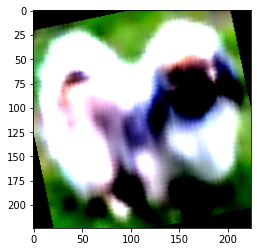

In [ ]:
for x, y in trainloader:
  break
plt.imshow(x[1].permute(2,1,0).permute(1, 0, 2))

In [ ]:
sm = nn.Softmax(dim=1)
probs = sm(model(x.to(device)))
print(probs[1])
y_pred = torch.argmax(probs, axis=1)
print(y_pred[1], y[1])

tensor([2.9543e-07, 2.9603e-07, 5.1764e-05, 2.8392e-05, 7.5131e-07, 9.9990e-01,
        1.0576e-06, 1.7390e-05, 4.7287e-08, 8.2051e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(5, device='cuda:0') tensor(5)


In [ ]:
 classes[5]

'dog'

In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jacobgil/pytorch-grad-cam to /tmp/pip-req-build-0kouze0k
  Running command git clone -q https://github.com/jacobgil/pytorch-grad-cam /tmp/pip-req-build-0kouze0k
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import numpy as np

image_array = []
for x, y in trainloader:
  x = np.array(x)
  x = np.rollaxis(x, 1, 4)
  image_array.append(x)

image_array = np.concatenate(image_array, axis=0)

In [ ]:
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

#model = models.resnet50(pretrained=True)
model.eval()
img = image_array[3, :, :, :]

plt.imshow(img)

#img = np.array(Image.open(requests.get(image_url, stream=True).raw))
img = cv2.resize(img, (224, 224))
img = np.float32(img)
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).cuda()

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(4)]
target_layers = [model.layer4]
with GradCAMPlusPlus(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)